Logistic regression

In [22]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame({'x':[1,2,3,4,5,6,7,8,9,10],'y':[0,0,0,0,1,0,1,1,1,1]})

logit = LogisticRegression(fit_intercept = True, penalty = None, class_weight = 'balanced')
scaler = StandardScaler()
df["x scaled"] = scaler.fit_transform(df[["x"]])
logit.fit(df[["x scaled"]], df["y"])

p = [i[1] for i in logit.predict_proba(df[["x scaled"]])]

df['Predicted Probability'] = p # logit.predict(df[['x']])
df = df.loc[:,["x","y","Predicted Probability"]]
df.head(10)

,x,y,Predicted Probability
0,1,0,0.002851
1,2,0,0.010400
2,3,0,0.037185
3,4,0,0.124295
4,5,1,0.342811
5,6,0,0.657189
6,7,1,0.875705
7,8,1,0.962815
8,9,1,0.989600
9,10,1,0.997149


Anomaly detection

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib import pyplot

df = pd.read_csv("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/USW00023190.csv.gz",
                 compression = 'gzip',
                 names = ['station','date','datatype','value','U1','U2','U3','U4'],
                 low_memory = False)

df["date"] = pd.to_datetime(df["date"].astype(str))
df = df.loc[(df["datatype"].isin(["TMIN","TMAX","PRCP"])) & (df["date"] >= "2019-01-01"), ["date", "datatype", "value"]]

df["value"] = np.where(np.array(df["datatype"]) == "PRCP", np.round(np.array(df["value"])/100/2.54, 2), np.round(np.array(df["value"])/10 * 1.8 + 32, 0))
df = df.pivot(index = "date", columns = "datatype", values = "value").dropna().rename_axis(None, axis = 1).reset_index(inplace = False)

df["TAVG"] = (df["TMIN"] + df["TMAX"]) / 2
df = df.rename(columns = {"date": "Date", "TMAX": "High Temperature", "TMIN": "Low Temperature", "TAVG": "Average Temperature", "PRCP": "Rainfall"})

X = np.array(df["Average Temperature"]).reshape(-1,1)

eps = 2
min_samples = 14

clusters = DBSCAN(eps = eps, min_samples = min_samples).fit_predict(X)
df = df.assign(Anomaly = clusters)
df.tail()

,Date,Rainfall,High Temperature,Low Temperature,Average Temperature,Anomaly
1932,2024-04-18,0.0,61.0,53.0,57.0,0
1933,2024-04-19,0.0,58.0,54.0,56.0,0
1934,2024-04-20,0.0,60.0,56.0,58.0,0
1935,2024-04-21,0.0,63.0,54.0,58.5,0
1936,2024-04-22,0.0,60.0,55.0,57.5,0


Time series decomposition

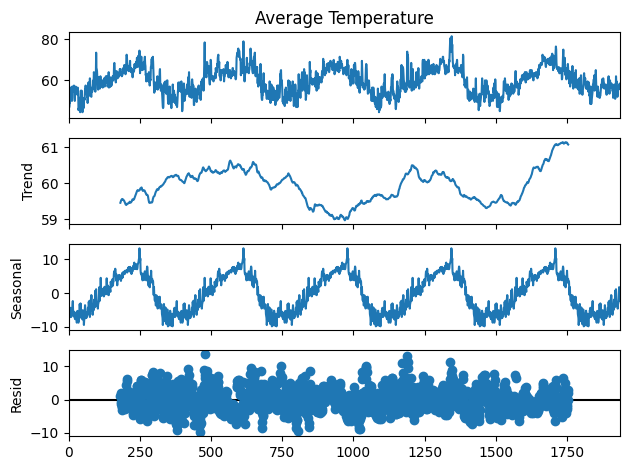

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = df["Average Temperature"]
result = seasonal_decompose(series, model = 'additive', period = 365)
result.plot()
pyplot.show()

In [25]:
df.dtypes

Date                   datetime64[ns]
Rainfall                      float64
High Temperature              float64
Low Temperature               float64
Average Temperature           float64
Anomaly                         int64
dtype: object

In [26]:
monthly = df.groupby(pd.Grouper(key = 'Date', axis = 0, freq = 'M')).mean()
monthly.head(40)

,Rainfall,High Temperature,Low Temperature,Average Temperature,Anomaly
Date,,,,,
2019-01-31,0.237419,63.258065,43.096774,53.177419,0.000000
2019-02-28,0.188214,58.821429,41.535714,50.178571,0.000000
2019-03-31,0.121613,65.193548,45.612903,55.403226,0.000000
2019-04-30,0.003000,68.600000,51.066667,59.833333,0.000000
2019-05-31,0.060645,66.870968,51.645161,59.258065,0.000000
2019-06-30,0.000000,68.766667,56.233333,62.500000,0.000000
2019-07-31,0.000000,73.193548,57.451613,65.322581,0.000000
2019-08-31,0.000000,74.419355,57.870968,66.145161,0.000000
2019-09-30,0.000000,78.533333,57.600000,68.066667,0.000000


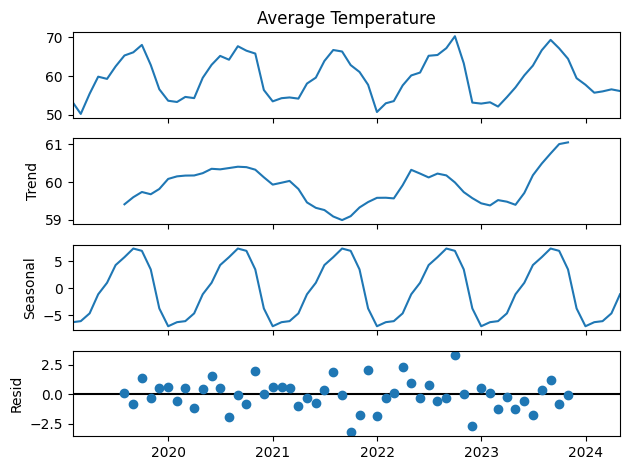

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = monthly["Average Temperature"]
result = seasonal_decompose(series, model = 'additive', period = 12)
result.plot()
pyplot.show()

Clustering

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

temps = [["Bakersfield", 78,  53, 65.5],
        ["Burbank", 77, 55, 66],
        ["Fresno", 77,  51, 64],
        ["Long Beach", 74,  55, 64.5],
        ["Los Angeles", 70,  56, 63],
        ["Sacramento", 74,  48, 61],
        ["San Diego", 71,  57, 64],
        ["San Francisco", 66,  50, 58],
        ["Santa Barbara", 70,  49, 59.5]]
df = pd.DataFrame(temps, columns = ["Station", "High Temperature", "Low Temperature", "Average Temperature"])
data_1d = list(zip(df["Average Temperature"].tolist()))
data_2d = list(zip(df["Low Temperature"].tolist(), df["High Temperature"].tolist()))

df = df.set_index("Station")

df.head(10)

,High Temperature,Low Temperature,Average Temperature
Station,,,
Bakersfield,78,53,65.5
Burbank,77,55,66.0
Fresno,77,51,64.0
Long Beach,74,55,64.5
Los Angeles,70,56,63.0
Sacramento,74,48,61.0
San Diego,71,57,64.0
San Francisco,66,50,58.0
Santa Barbara,70,49,59.5


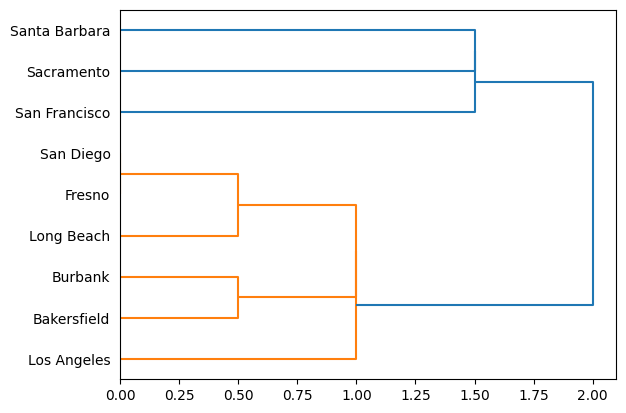

In [29]:
distances = linkage(data_1d, metric = "euclidean")
dendrogram(distances, leaf_rotation = 0, leaf_font_size = 10, labels = df.index, orientation = "right") # can change threshold colors as well
plt.show()

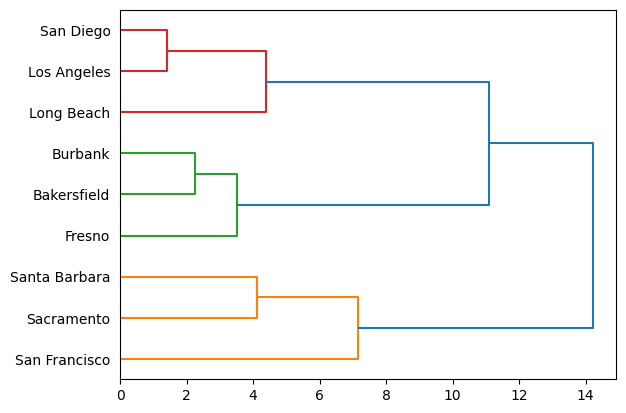

In [30]:
distances = linkage(data_2d, method = "ward", metric = "euclidean")
dendrogram(distances, leaf_rotation = 0, leaf_font_size = 10, labels = df.index, orientation = "right") # can change threshold colors as well
plt.show()

Seaborn dendrogram

In [31]:
df.head(10)

,High Temperature,Low Temperature,Average Temperature
Station,,,
Bakersfield,78,53,65.5
Burbank,77,55,66.0
Fresno,77,51,64.0
Long Beach,74,55,64.5
Los Angeles,70,56,63.0
Sacramento,74,48,61.0
San Diego,71,57,64.0
San Francisco,66,50,58.0
Santa Barbara,70,49,59.5


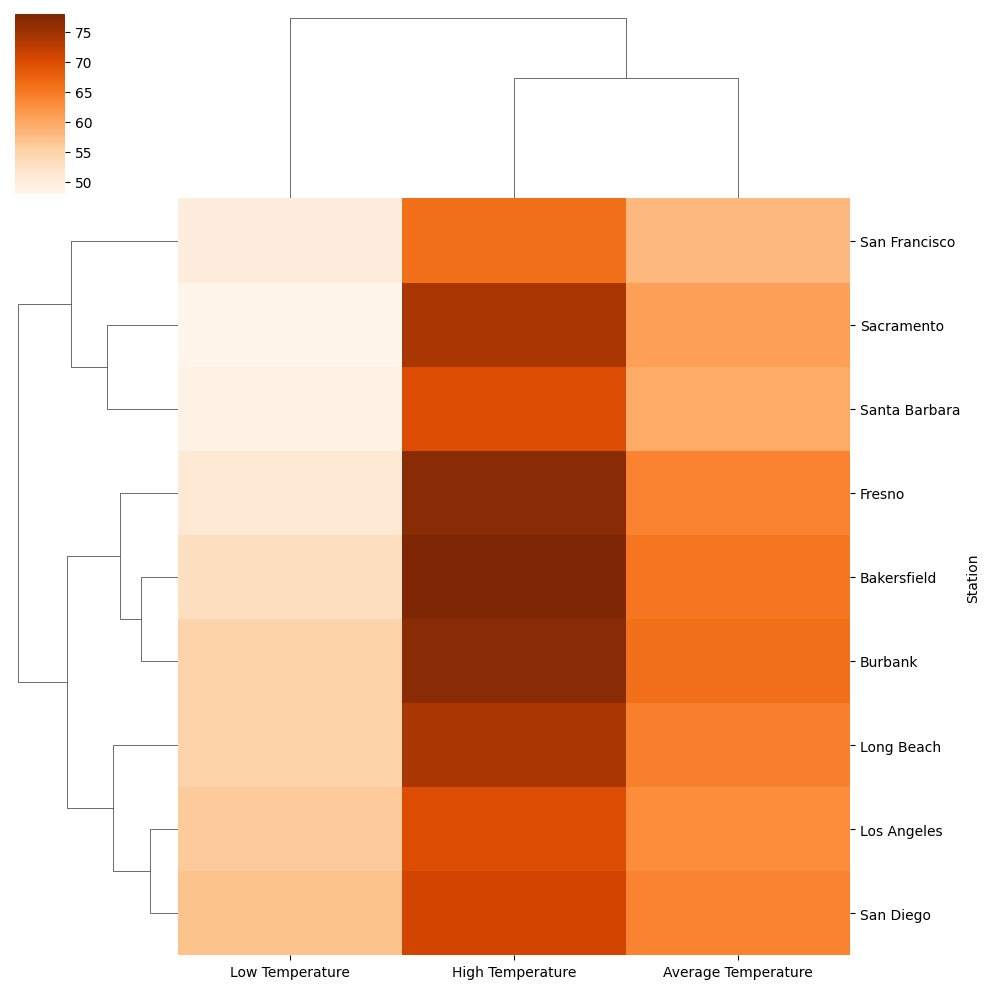

In [32]:
sns.clustermap(df, cmap = "Oranges")
plt.show()